In [26]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tweezepy import AV, PSD
import os
import glob

In [27]:
def openFiles(folderPath: str, numRef: int, numExp: int, fps: int) -> pd.DataFrame:
    
    """
    Opens the folder and stores the data within the files into a Pandas Dataframe

    Parameters
    ----------
    folderPath : str
        The path to the folder containing the *.txt data files.
    numRef : int
        The number of reference beads in the experiment.
    numExp : int
        The number of experimental beads in the experiment.
    fps : int
        The acquisition rate of the camera.

    Returns
    -------
    dataFrame : pd.DataFrame       
        A Pandas DataFrame created from the files.

    Examples
    --------
    >>> data = openFiles("C:\\Users\\dataTSV", 
                        numRef=3, 
                        numExp=2, 
                        fps=400)
    """


    # Checks to see if the path is correct and returns an error if it is not
    if os.path.exists(folderPath):
        print("Using: " + folderPath)
    else: 
        raise FileNotFoundError('No such file or directory.')

    # Initialization of that list
    nameList = ["inf","linearMotor","rotationalMotor"]

    # Adds names to the list depending on how many beads were given
    for i in range(numRef):
        nameList = nameList + ["xRefBead"+str(i+1), "yRefBead"+str(i+1), "zRefBead"+str(i+1)]
    for i in range(numExp): 
        nameList = nameList + ["xExpBead"+str(i+1), "yExpBead"+str(i+1), "zExpBead"+str(i+1)]

    # Stores the file names into a list
    files = glob.glob(folderPath + '/*.txt')

    # Turns the data into a table, then concatenates this table into a Pandas dataframe 
    dataTable = [pd.read_table(files[i], names=nameList) for i in range(len(files))]
    dataFrame = pd.concat([pd.DataFrame(dataTable[i], columns=nameList) for i in range(len(files))],
            ignore_index=True)

    # Uses the conversion values to convert the pixels to nanometers. Also converts the z-axis to nm from um
    xConv = 64.6
    yConv = 64.7
    for column in dataFrame.columns:
        if column[0] == 'x': dataFrame[column] = dataFrame[column]*xConv
        if column[0] == 'y': dataFrame[column] = dataFrame[column]*yConv
        if column[0] == 'z': dataFrame[column] = dataFrame[column]*1000

    # Creates a time series from the frames per second of the camera and adds it to the dataframe
    dataFrame.insert(0, "timeVector", pd.Series(range(len(dataFrame)))/fps)

    return(dataFrame)

def findTetheredBeads(dataFrame: pd.DataFrame, loc: list) -> list:

    """
    Takes in the dataFrame and allows the user to select the beads that they find to be thethered beads

    Parameters
    ----------
    dataFrame : pd.DataFrame
        The data in a Pandas DataFrame.
    loc : list
        Indicies to perform the calculations over. Of the form [startIndex, StopIndex].

    Returns
    -------
    goodBeads : list of str
        A list of strings of the good tethered beads.

    Examples
    --------
    >>> tetheredBeads = findTetheredBeads(pd.DataFrame, 
                                        loc=[lowForceStartIndex, lowForceStopIndex])
    >>> print(tetheredBeads)
    [expBead1, expBead2, expBead3]
    """
    # Stores the indexes from
    startIndex = loc[0]
    endIndex = loc[1]
    
    # Goes through and plots (the different beads) - refbead1 so the user can determine which beads are tethers and which are reference beads.
    for column in dataFrame.columns:
        if column[0] == 'z': a = plt.plot(dataFrame["timeVector"][startIndex:endIndex], dataFrame[column][startIndex:endIndex] - dataFrame['zExpBead1'][startIndex:endIndex], 
                                        label=column)
    # Labelling of the plot
    plt.title("Beads at low force"); plt.xlabel("Time (s)"); plt.ylabel("nm"); plt.hlines(0, dataFrame["timeVector"][startIndex], dataFrame["timeVector"][endIndex], label="y=0"); plt.legend(loc='best');
    plt.show()
    # Asks the user how many tethered beads there are
    numGoodBeads = int(input("Number of beads you want to use:"))

    # Asks the user to list the beads they want to analyze and checks if the user properly did that.
    goodBeads = []
    for i in range(numGoodBeads):
        goodBead = input("Which beads (one at a time):") # User input

        if goodBead in dataFrame.columns: # Checks if the beads are good
            goodBeads = goodBeads + [goodBead[1:]]
        else: print(goodBead + " is not a valid bead and will not be considered in analysis.")

    # Goes through the good beads and calculates the variance in the different axes
    for i in goodBeads:
        print("For " + i + ":")
        print('\tThe low force x-variance is:', np.var(dataFrame["x" + i][startIndex:endIndex]),)
        print('\tThe low force y-variance is:', np.var(dataFrame["y" + i][startIndex:endIndex]))
        print('\tThe low force z-variance is:', np.var(dataFrame["z" + i][startIndex:endIndex]))
        plt.plot (dataFrame["timeVector"][startIndex:endIndex], dataFrame["z" + i][startIndex:endIndex], # plots the good beads at low force
                label=i)
    # Labelling of the plot
    plt.title('Z-data at low force'); plt.xlabel('Time (s)'); plt.ylabel('Distance (nm)'); plt.legend(loc='best');
    plt.show() 
    
    # Subtracts the reference bead from the tethered beads 
    for i in goodBeads:
        dataFrame["x" + i] = dataFrame["x" + i] - dataFrame["xExpBead2"]
        dataFrame["y" + i] = dataFrame["y" + i] - dataFrame["yExpBead2"]
        dataFrame["z" + i] = dataFrame["z" + i] - dataFrame["zExpBead2"]

    return goodBeads

def calculateTetherExtension(dataFrame: pd.DataFrame, goodBeads: list[str], lowForceIndex: list) -> pd.DataFrame:

    """  
    Calculates the Tether's extension.

    Parameters
    ----------
    dataFrame : pd.DataFrame
        The data in a pandas dataframe.
    goodBeads : list of str
        The list of the names of the tethered beads.
    lowForceIndex : list
        The start and stop index of the region of interest. Of the form [startIndex, stopindex].

    Returns
    -------
    dataFrame : pd.DataFrame
        The data in a Pandas DataFrame with a new vector for the tether extension.

    Examples
    --------
    >>> calculateTetherExtension(pd.DataFrame, 
                                goodBeads=[expBead1, expBead2], 
                                lowForceIndex=[startIndex, stopIndex])
    """

    # Start and Stop indexes to run the analysis on
    startIndex = lowForceIndex[0]
    endIndex = lowForceIndex[1]

    for i in goodBeads:
        # This sorts the data so that a percentage of it can be used to average for the glass position
        sortedZdata = np.sort(dataFrame["z" + i][startIndex:endIndex])

        # Averages the sorted array and then subtracts off the beads diameter to get the final bead position
        glassPosition = np.mean(np.sort(dataFrame["z" + i][startIndex:endIndex])[0:30])
        print('The glass position is: ', glassPosition)

        # Calculates the extension and adds it to the dataframe
        dataFrame.insert(len(dataFrame.columns), "extension" + i, dataFrame["z" + i] - glassPosition)

        # Plots a histogram of the tethered beads
        plt.hist(dataFrame["z" + i][startIndex:endIndex], bins = 100, color='#5ADD4D')
        plt.axvline(glassPosition, color="red", label="glass position")

    # Labelling of the plot
    plt.title('Z-data at low force'); plt.ylabel('Count'); plt.xlabel('Distance (nm)');

    return dataFrame

def calculateForce(dataFrame: pd.DataFrame, goodBeads: list[str], loc: list, fps: int, beadRadius: int) -> list:
      
    """
    Calculates the force at a given index

    Parameters
    ----------
    dataFrame : pd.DataFrame
        A Dataframe of the data
    goodBeads : list of str
        A list of the tethered beads.
    loc : list
       Indicies to perform the calculations over.
    fps : int
        The acquisition rate of the camera in frames per second.
    beadRadius : int
        The radius of the beads being used in nm. 

    Returns
    -------
    forcePSD : list
        A list of forces calculated using Power Spectral Density.
    forceAV : list
        A list of forces calculated using Allan Variance.
    forceEPT : list
        A list of forces calculated using simple Equipartition Theorem F = k_BT*L/<x^2>.

    Examples
    --------
    >>> forcePSD, forceAV, forceEPT = calculateForce(pd.DataFrame, goodBeads=[expBead1, expBead2], loc=[startIndex, stopIndex], fps=400, beadRadius=1400)
    >>> print(forcePSD)
    [0.020397852, 0.034398144]
    """


    # Start and stop indices for the calculations
    startIndex = loc[0]
    endIndex = loc[1]

    # Initializing of the empty arrays
    forcePSD = []
    forceAV = []
    forceEPT = []

    # Calculates the force for each of the good beads
    for i in goodBeads:
        # Fitting of the data to PSD and AV
        psd = PSD(dataFrame["x" + i][startIndex:endIndex], fps, bins=5); psd.mlefit(viscosity=1e-9, radius=beadRadius)
        av = AV(dataFrame["x" + i][startIndex:endIndex], fps); av.mlefit(viscosity=1e-9, radius=beadRadius)

        # Calculation of the forces using PSD, AV, equipartition theorem
        forcePSD = forcePSD + [psd.results['k']*np.mean(dataFrame["extension" + i][startIndex:endIndex])]
        forceAV  = forceAV  + [av.results['k']*np.mean(dataFrame["extension" + i][startIndex:endIndex])]
        forceEPT = forceEPT + [4.1*np.mean(dataFrame["extension" + i][startIndex:endIndex])/np.var(dataFrame["x" + i][startIndex:endIndex])]

    return forcePSD, forceAV, forceEPT


def downsampleData(dataFrame: pd.DataFrame, sampleRate: int, downsampleRate: int) -> pd.DataFrame:
    


    return 





In [28]:
## MAIN FUNCTION 
def main():
    folderPath = input("Type the path to the folder location:")
    numRef = int(input("Number of reference beads:"))
    numExp = int(input("Number of experimental beads:"))
    fps = int(input("Frames per second:"))

    dataFrame = openFiles(folderPath, numRef, numExp, fps);

    lowForce = []

    for index in dataFrame.itertuples():
        if dataFrame['linearMotor'][index[0]] <= 15: lowForce = lowForce + [index[0]]
        if index[0] % 50000 == 0: print("Finding the low force points") 
    
    lowForceIdx = [min(lowForce), max(lowForce)]

    tetherBeads = findTetheredBeads(dataFrame, lowForceIdx);
    dataFrame = calculateTetherExtension(dataFrame, tetherBeads, lowForceIdx);
    forcePSD, forceAV, forceEPT = calculateForce(dataFrame, tetherBeads, lowForceIdx, fps, 1400)

    print("Force using PSD:", forcePSD[0]);print("Force using AV:", forceAV[0]);print("Force using EPT:", forceEPT[0]);

Using: C:\Users\maddr\OneDrive\Documents\MTCode\Magnetic-Tweezers\Data\October\6\1\dataTSV
Finding the low force points
Finding the low force points
Finding the low force points
Finding the low force points
Finding the low force points


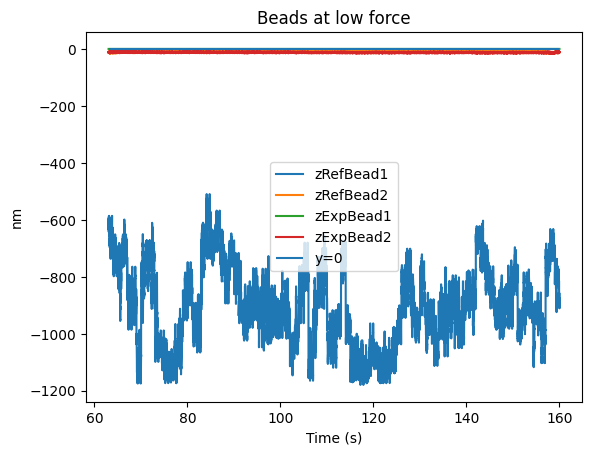

For RefBead1:
	The low force x-variance is: 5532.6283756205885
	The low force y-variance is: 39278.77953750525
	The low force z-variance is: 19403.95842839193


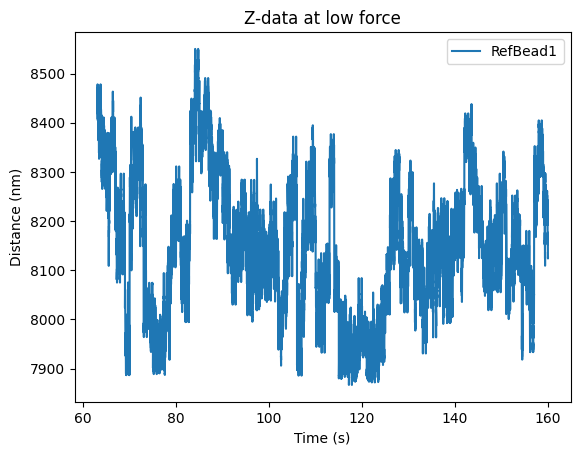

The glass position is:  -1161.6473333333333
Force using PSD: 0.18043813976484083
Force using AV: 0.24968361330058209
Force using EPT: 0.20087127711385755


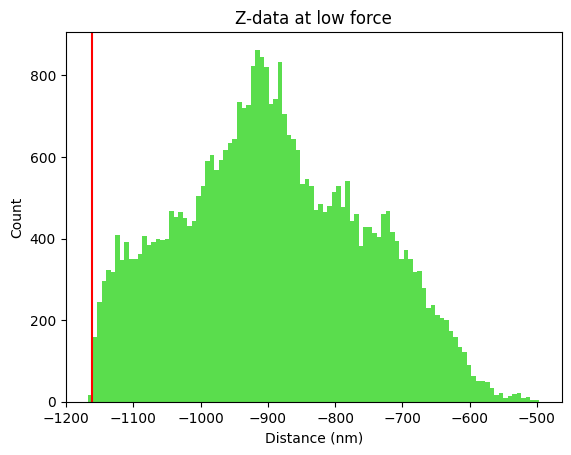

In [29]:
main()